# Libraries

In [66]:
import os
from datetime import datetime

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch import optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.transforms import v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.tensorboard import SummaryWriter
from torchvision.ops import box_iou

from torchmetrics.detection.mean_ap import MeanAveragePrecision

from utils import extract_zip, get_model_cls, get_model

# Default device

In [2]:
device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else "cpu"
torch.set_default_device(device)
device

device(type='cuda')

# Extract zip

In [3]:
extract_zip("honeybee.zip")

Successfully extracted 'honeybee.zip' to '.'


# Data Analysis and Pre-processing

### 1. Count

In [4]:
img_dir = "honeybee/img"
mask_dir = "honeybee/gt-dots"

images = sorted([f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))])
masks = sorted([f for f in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, f))])

print("Images: ", len(images))
print("Masks: ", len(masks))

Images:  118
Masks:  128


We can see the imbalace in data, next step would be to pre-process and filter out only unique files

### 2. Naming Style

In [5]:
images[0], masks[0]

('beeType1_008.jpg', 'dots008.png')

We can see the image files' naming style and masks files' naming style, the first word in the image file name just before the underscore must be the all the different classes of bees image present in the dataset and the number following must be the unique identifier for that image file which should correspond to the masks file for that image.

### 3. Filter valid image and mask files

In [6]:
img_files = []
mask_files = []
cls = []
ids = []

for file in images:
    splited_base_name = file.split(".")[0].split("_")
    cls_name, unique_id = splited_base_name[0], splited_base_name[1]

    img_file = f"{img_dir}/{file}"
    mask_file = f"{mask_dir}/dots{unique_id}.png"
    
    if os.path.exists(mask_file):
        img_files.append(img_file)
        mask_files.append(mask_file)
        cls.append(cls_name)
        ids.append(unique_id)

df = pd.DataFrame({"image": img_files, "mask": mask_files, "id": ids, "type": cls})
df["type_label"] = pd.factorize(df["type"])[0] + 1
df.head()

,image,mask,id,type,type_label
0,honeybee/img/beeType1_008.jpg,honeybee/gt-dots/dots008.png,008,beeType1,1
1,honeybee/img/beeType1_009.jpg,honeybee/gt-dots/dots009.png,009,beeType1,1
2,honeybee/img/beeType1_010.jpg,honeybee/gt-dots/dots010.png,010,beeType1,1
3,honeybee/img/beeType1_011.jpg,honeybee/gt-dots/dots011.png,011,beeType1,1
4,honeybee/img/beeType1_012.jpg,honeybee/gt-dots/dots012.png,012,beeType1,1


### 4. Generate bounding boxes and labels

Keeping the dot in mask image as center, we generate 32x32 bounding box coordinates around it. This size was choosen from the observation.

In [7]:
def generate_boxes_from_dots(mask_path, box_size=32):
    mask = cv2.imread(mask_path, 0)
    _, thresh = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    num_labels, _, _, centroids = cv2.connectedComponentsWithStats(thresh)

    boxes = []
    h, w = mask.shape
    half = box_size // 2

    # Skip background (label = 0)
    for i in range(1, num_labels):
        cx, cy = centroids[i]
        cx = int(cx)
        cy = int(cy)
        # Compute bounding box coordinates
        x1 = max(0, cx - half)
        y1 = max(0, cy - half)
        x2 = min(w - 1, cx + half)
        y2 = min(h - 1, cy + half)
        boxes.append([x1, y1, x2, y2])
    return boxes

In [8]:
df["bbox"] = df["mask"].apply(generate_boxes_from_dots)
# since we know we only have one class we can directly add label for each bbox
df["bbox_label"] = df["bbox"].apply(lambda x:[1 for i in x])
df

,image,mask,id,type,type_label,bbox,bbox_label
0,honeybee/img/beeType1_008.jpg,honeybee/gt-dots/dots008.png,008,beeType1,1,"[[155, 1, 187, 33], [422, 1, 454, 33], [535, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,honeybee/img/beeType1_009.jpg,honeybee/gt-dots/dots009.png,009,beeType1,1,"[[571, 23, 603, 55], [423, 66, 455, 98], [59, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,honeybee/img/beeType1_010.jpg,honeybee/gt-dots/dots010.png,010,beeType1,1,"[[556, 29, 588, 61], [55, 54, 87, 86], [406, 7...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,honeybee/img/beeType1_011.jpg,honeybee/gt-dots/dots011.png,011,beeType1,1,"[[549, 0, 581, 23], [546, 37, 578, 69], [28, 4...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,honeybee/img/beeType1_012.jpg,honeybee/gt-dots/dots012.png,012,beeType1,1,"[[0, 36, 28, 68], [535, 49, 567, 81], [396, 55...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...,...,...
113,honeybee/img/beeType1_121.jpg,honeybee/gt-dots/dots121.png,121,beeType1,1,"[[507, 0, 539, 24], [484, 14, 516, 46], [449, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
114,honeybee/img/beeType1_122.jpg,honeybee/gt-dots/dots122.png,122,beeType1,1,"[[120, 23, 152, 55], [471, 35, 503, 67], [271,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
115,honeybee/img/beeType1_123.jpg,honeybee/gt-dots/dots123.png,123,beeType1,1,"[[374, 13, 406, 45], [85, 36, 117, 68], [197, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
116,honeybee/img/beeType1_124.jpg,honeybee/gt-dots/dots124.png,124,beeType1,1,"[[458, 0, 490, 23], [98, 7, 130, 39], [168, 10...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [9]:
df.to_csv("honeybee.csv", index=False)

### 5. Train, Val and Test split

In [10]:
train_df, sub_df = train_test_split(df, test_size=0.2)
train_df = train_df.reset_index(drop=True)

val_df, test_df = train_test_split(sub_df, test_size=0.5)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [11]:
train_df.head()

,image,mask,id,type,type_label,bbox,bbox_label
0,honeybee/img/beeType1_038.jpg,honeybee/gt-dots/dots038.png,038,beeType1,1,"[[395, 39, 427, 71], [14, 47, 46, 79], [282, 7...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,honeybee/img/beeType1_025.jpg,honeybee/gt-dots/dots025.png,025,beeType1,1,"[[580, 9, 612, 41], [123, 20, 155, 52], [0, 22...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,honeybee/img/beeType1_120.jpg,honeybee/gt-dots/dots120.png,120,beeType1,1,"[[146, 0, 178, 22], [499, 0, 531, 24], [521, 0...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,honeybee/img/beeType1_010.jpg,honeybee/gt-dots/dots010.png,010,beeType1,1,"[[556, 29, 588, 61], [55, 54, 87, 86], [406, 7...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,honeybee/img/beeType1_108.jpg,honeybee/gt-dots/dots108.png,108,beeType1,1,"[[388, 8, 420, 40], [80, 12, 112, 44], [100, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [12]:
val_df.head()

,image,mask,id,type,type_label,bbox,bbox_label
0,honeybee/img/beeType1_023.jpg,honeybee/gt-dots/dots023.png,023,beeType1,1,"[[492, 8, 524, 40], [212, 28, 244, 60], [3, 69...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,honeybee/img/beeType1_101.jpg,honeybee/gt-dots/dots101.png,101,beeType1,1,"[[363, 0, 395, 28], [608, 46, 639, 78], [12, 5...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,honeybee/img/beeType1_041.jpg,honeybee/gt-dots/dots041.png,041,beeType1,1,"[[541, 0, 573, 29], [48, 14, 80, 46], [426, 34...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,honeybee/img/beeType1_123.jpg,honeybee/gt-dots/dots123.png,123,beeType1,1,"[[374, 13, 406, 45], [85, 36, 117, 68], [197, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,honeybee/img/beeType1_036.jpg,honeybee/gt-dots/dots036.png,036,beeType1,1,"[[612, 3, 639, 35], [259, 22, 291, 54], [169, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [13]:
test_df.head()

,image,mask,id,type,type_label,bbox,bbox_label
0,honeybee/img/beeType1_066.jpg,honeybee/gt-dots/dots066.png,066,beeType1,1,"[[2, 0, 34, 26], [120, 7, 152, 39], [5, 11, 37...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,honeybee/img/beeType1_059.jpg,honeybee/gt-dots/dots059.png,059,beeType1,1,"[[607, 43, 639, 75], [52, 91, 84, 123], [465, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,honeybee/img/beeType1_024.jpg,honeybee/gt-dots/dots024.png,024,beeType1,1,"[[214, 14, 246, 46], [124, 35, 156, 67], [612,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,honeybee/img/beeType1_067.jpg,honeybee/gt-dots/dots067.png,067,beeType1,1,"[[90, 0, 122, 21], [108, 17, 140, 49], [565, 3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,honeybee/img/beeType1_097.jpg,honeybee/gt-dots/dots097.png,097,beeType1,1,"[[428, 0, 460, 26], [174, 30, 206, 62], [511, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [14]:
train_df.shape, val_df.shape, test_df.shape

((94, 7), (12, 7), (12, 7))

### 6. Dataset and Dataloader

In [15]:
class BeeDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.df = df
        self.length = self.df.shape[0]
        self.t = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float, scale=True)
        ])

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        img = cv2.imread(self.df["image"].iloc[idx], cv2.IMREAD_COLOR_RGB)
        target = {}
        target["boxes"] = torch.tensor(self.df["bbox"][idx])
        target["labels"] = torch.tensor(self.df["bbox_label"][idx])
        return self.t(img), target


def custom_collate(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    return data, target

In [16]:
train_data = BeeDataset(train_df)
val_data = BeeDataset(val_df)
test_data = BeeDataset(test_df)

BATCH_SIZE = 1
train_loader = DataLoader(train_data, BATCH_SIZE, collate_fn=custom_collate)
val_loader = DataLoader(val_data, BATCH_SIZE, collate_fn=custom_collate)
test_loader = DataLoader(test_data, BATCH_SIZE, collate_fn=custom_collate)

In [17]:
def plot_img_and_bbox(img, boxes, rgb=None):
    if rgb is None:
        rgb = (0, 0, 255)
    for (x1, y1, x2, y2) in boxes:
        img = cv2.rectangle(img, (x1, y1), (x2, y2), rgb, 1)
    plt.imshow(img)

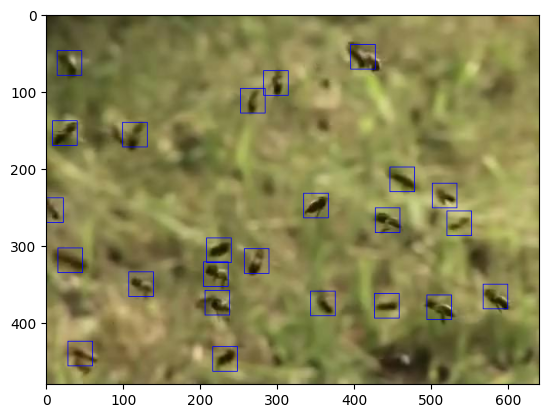

In [18]:
train_iter = iter(train_loader)
eg_data, eg_target = next(train_iter)

img = np.ascontiguousarray((eg_data[0] * 255).to(torch.uint8).permute(1, 2, 0).to("cpu").numpy())
boxes = (eg_target[0]["boxes"]).to("cpu").numpy()

plot_img_and_bbox(img, boxes)

# Model, Optimizer and Scheduler

We will transfer learn a very popular object detection model called Faster RCNN with FPN(Feature pyramid network - helps small sized objects)

In [19]:
model = get_model_cls()

INITIAL_LEARNING_RATE = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005

optimizer = optim.SGD(model.parameters(), lr=INITIAL_LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", 0.1, 5)

# Training Loop

In [20]:
EPOCH = 50

# Train
loss_total = []
loss_classifier = []
loss_box_reg = []
loss_objectness =  []

# Validation
loss_total_val = []
loss_classifier_val = []
loss_box_reg_val = []
loss_objectness_val =  []

for epoch in range(1, EPOCH + 1):

    # Train
    epoch_loss_total = epoch_loss_classifier = epoch_loss_box_reg = epoch_loss_objectness = 0.0
    for data, target in train_data:
        loss_dict = model([data], [target])

        # Classifier loss
        epoch_loss_classifier += loss_dict["loss_classifier"].item() 
        # loss_classifier.append(loss_dict["loss_classifier"].item())

        # BBox regressor loss
        epoch_loss_box_reg += loss_dict["loss_box_reg"].item()
        # loss_box_reg.append(loss_dict["loss_box_reg"].item())

        # Objectness loss
        epoch_loss_objectness = loss_dict["loss_objectness"].item()
        # loss_objectness.append(loss_dict["loss_objectness"].item())
        
        # Total loss
        total = sum(loss_dict.values())
        epoch_loss_total += total.item() 
        # loss_total.append(total.item())
        
        optimizer.zero_grad()
        total.backward()
        optimizer.step()
    
    scheduler.step(total)

    # Train
    epoch_loss_total = epoch_loss_total / len(train_loader)
    loss_total.append(epoch_loss_total)
    
    epoch_loss_classifier = epoch_loss_classifier / len(train_loader)
    loss_classifier.append(epoch_loss_classifier)
    
    epoch_loss_box_reg = epoch_loss_box_reg / len(train_loader)
    loss_box_reg.append(epoch_loss_box_reg)
    
    epoch_loss_objectness = epoch_loss_objectness / len(train_loader)
    loss_objectness.append(epoch_loss_objectness)

    print(f"Epoch: {epoch}\tTrain Losses\tTotal: {epoch_loss_total}\tClassifier: {epoch_loss_classifier}\tBbox: {epoch_loss_box_reg}\tObjectness: {epoch_loss_objectness}")
    

    # Validation
    epoch_loss_total_val = epoch_loss_classifier_val = epoch_loss_box_reg_val = epoch_loss_objectness_val = 0.0
    with torch.no_grad():
        for data, target in val_data:
            loss_dict = model([data], [target])

            # Classifier loss
            epoch_loss_classifier_val += loss_dict["loss_classifier"].item() 
            # loss_classifier_val.append(loss_dict["loss_classifier"].item())
    
            # BBox regressor loss
            epoch_loss_box_reg_val += loss_dict["loss_box_reg"].item()
            # loss_box_reg_val.append(loss_dict["loss_box_reg"].item())
    
            # Objectness loss
            epoch_loss_objectness_val = loss_dict["loss_objectness"].item()
            # loss_objectness_val.append(loss_dict["loss_objectness"].item())
            
            # Total loss
            total_val = sum(loss_dict.values())
            epoch_loss_total_val += total_val.item() 
            # loss_total_val.append(total_val.item())
    
    # Validation
    epoch_loss_total_val = epoch_loss_total_val / len(val_loader)
    loss_total_val.append(epoch_loss_total_val)
    
    epoch_loss_classifier_val = epoch_loss_classifier_val / len(val_loader)
    loss_classifier_val.append(epoch_loss_classifier_val)
    
    epoch_loss_box_reg_val = epoch_loss_box_reg_val / len(val_loader)
    loss_box_reg_val.append(epoch_loss_box_reg_val)
    
    epoch_loss_objectness_val = epoch_loss_objectness_val / len(val_loader)
    loss_objectness_val.append(epoch_loss_objectness_val)

    print(f"Epoch: {epoch}\tVal Losses\tTotal: {epoch_loss_total_val}\tClassifier: {epoch_loss_classifier_val}\tBbox: {epoch_loss_box_reg_val}\tObjectness: {epoch_loss_objectness_val}")
    print()

Epoch: 1	Train Losses	Total: 1.1381450951733487	Classifier: 0.3667458481690351	Bbox: 0.43065058257173194	Objectness: 0.00047007781711030515
Epoch: 1	Val Losses	Total: 0.8862412671248118	Classifier: 0.27455077817042667	Bbox: 0.536752313375473	Objectness: 0.003480535621444384

Epoch: 2	Train Losses	Total: 0.7949781233960009	Classifier: 0.26019920345316544	Bbox: 0.47579529215680794	Objectness: 0.0001495115340073058
Epoch: 2	Val Losses	Total: 0.6517998427152634	Classifier: 0.21093216414252916	Bbox: 0.3932672714193662	Objectness: 0.0015127935136357944

Epoch: 3	Train Losses	Total: 0.6694702138292029	Classifier: 0.2217579187547907	Bbox: 0.40667326748371124	Objectness: 0.0001374243936957197
Epoch: 3	Val Losses	Total: 0.5955537259578705	Classifier: 0.19471216450134912	Bbox: 0.3625451947251956	Objectness: 0.0016280352137982845

Epoch: 4	Train Losses	Total: 0.6075763255357742	Classifier: 0.2103903631263591	Bbox: 0.3646852044349021	Objectness: 0.00013950607798835066
Epoch: 4	Val Losses	Total: 0.5

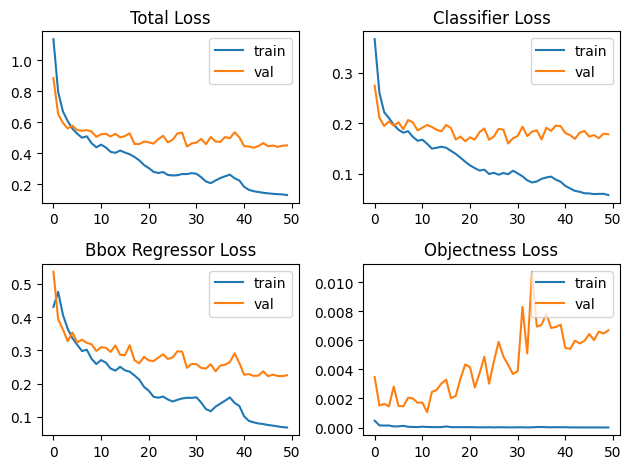

In [30]:
fig, axes = plt.subplots(2, 2)

axes[0][0].set_title("Total Loss")
axes[0][0].plot(loss_total, label="train")
axes[0][0].plot(loss_total_val, label="val")
axes[0][0].legend(loc="upper right")


axes[0][1].set_title("Classifier Loss")
axes[0][1].plot(loss_classifier, label="train")
axes[0][1].plot(loss_classifier_val, label="val")
axes[0][1].legend(loc="upper right")


axes[1][0].set_title("Bbox Regressor Loss")
axes[1][0].plot(loss_box_reg, label="train")
axes[1][0].plot(loss_box_reg_val, label="val")
axes[1][0].legend(loc="upper right")


axes[1][1].set_title("Objectness Loss")
axes[1][1].plot(loss_objectness, label="train")
axes[1][1].plot(loss_objectness_val, label="val")
axes[1][1].legend(loc="upper right")


fig.tight_layout()

In [31]:
fig.savefig("train.png")

# Save model

In [32]:
MODEL_PATH = "bee_count_fasterrcnn_resnet50_fpn.pt"

In [33]:
torch.save(model.state_dict(), MODEL_PATH)

# Load saved model

In [34]:
model_loaded = get_model(MODEL_PATH)
model_loaded.eval()
model_loaded

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

# Evaluate

In [71]:
def evaluate_detection(model, dataloader):
    model.eval()
    ious = []

    with torch.no_grad():
        for data, target in dataloader:
            outputs = model(data)

            for output, target in zip(outputs, target):
                gt_boxes = target["boxes"]
                pred_boxes = output["boxes"]

                if len(gt_boxes) == 0 or len(pred_boxes) == 0:
                    continue

                iou_matrix = box_iou(pred_boxes, gt_boxes)
                ious.append(iou_matrix.max().item())  # best IoU

    mean_iou = sum(ious) / len(ious)
    return mean_iou

In [72]:
iou = evaluate_detection(model_loaded, test_loader)
print(f"Mean IoU Test Set: {iou}")

Mean IoU Test Set: 0.9744073549906412


In [67]:
def evaluate_map(model, dataloader):
    metric = MeanAveragePrecision()
    model.eval()

    with torch.no_grad():
        for data, target in dataloader:
            outputs = model(data)
            metric.update(outputs, target)

    return metric.compute()

In [68]:
results = evaluate_map(model_loaded, test_loader)
print(results)

{'map': tensor(0.5869, device='cuda:0'), 'map_50': tensor(0.9589, device='cuda:0'), 'map_75': tensor(0.6393, device='cuda:0'), 'map_small': tensor(0.6150, device='cuda:0'), 'map_medium': tensor(0.6273, device='cuda:0'), 'map_large': tensor(-1., device='cuda:0'), 'mar_1': tensor(0.0250, device='cuda:0'), 'mar_10': tensor(0.2683, device='cuda:0'), 'mar_100': tensor(0.6856, device='cuda:0'), 'mar_small': tensor(0.6856, device='cuda:0'), 'mar_medium': tensor(0.6893, device='cuda:0'), 'mar_large': tensor(-1., device='cuda:0'), 'map_per_class': tensor(-1., device='cuda:0'), 'mar_100_per_class': tensor(-1., device='cuda:0'), 'classes': tensor(1, device='cuda:0', dtype=torch.int32)}


# Visualize Prediction

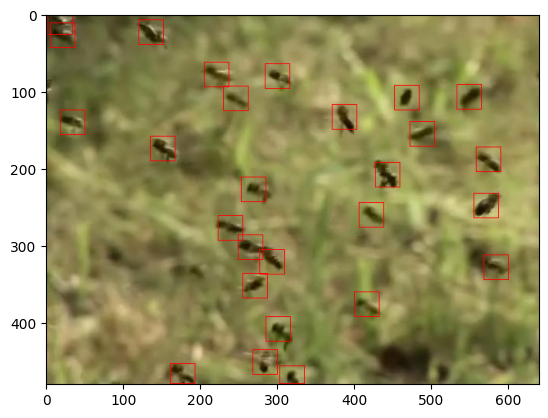

In [52]:
test_iter = iter(test_loader)
eg_data, eg_target = next(test_iter)

img = np.ascontiguousarray((eg_data[0] * 255).to(torch.uint8).permute(1, 2, 0).to("cpu").numpy())
boxes = (eg_target[0]["boxes"]).to("cpu").numpy()

plot_img_and_bbox(img, boxes, (255, 0, 0))